In [1]:
from copy import deepcopy
import os
from pathlib import Path
import random
import sys
sys.path.insert(0,'..')
from eppy.runner.run_functions import EnergyPlusRunError
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from doe_xstock.database import SQLiteDatabase
from doe_xstock.simulate import OpenStudioModelEditor, Simulator
from doe_xstock.utilities import get_data_from_path, split_lines, read_json, write_data, write_json

In [59]:
plt.rcParams['axes.xmargin'] = 0
plt.rcParams['axes.ymargin'] = 0
SIMULATION_OUTPUT_DIRECTORY = Path('/Users/kingsleyenweye/Desktop/INTELLIGENT_ENVIRONMENT_LAB/doe_xstock/energyplus_simulation')
DATABASE_FILEPATH = Path('/Users/kingsleyenweye/Desktop/INTELLIGENT_ENVIRONMENT_LAB/doe_xstock/database.db')
NEIGHBOURHOOD_FILEPATH = Path('/Users/kingsleyenweye/Desktop/INTELLIGENT_ENVIRONMENT_LAB/doe_xstock/doe_xstock/data/neighborhoods/travis_county.json')
SCHEDULES_FILENAME = Path('schedules.csv')
IDD_FILEPATH = Path('/Applications/EnergyPlus-9-6-0/PreProcess/IDFVersionUpdater/V9-6-0-Energy+.idd')
NEIGHBOURHOOD = read_json(NEIGHBOURHOOD_FILEPATH)
DATABASE = SQLiteDatabase(DATABASE_FILEPATH)
OUTPUT_VARIABLES = [
    'Lights Electricity Energy','Electric Equipment Electricity Energy',
    'Zone Air Temperature','Zone Air Relative Humidity',
    'Zone Thermostat Cooling Setpoint Temperature','Zone Thermostat Heating Setpoint Temperature',
    'Water Heater Heating Energy',
    'Zone Predicted Sensible Load to Setpoint Heat Transfer Rate',
    'Zone Predicted Moisture Load Moisture Transfer Rate',
    'Air System Outdoor Air Mass Flow Rate',
    'Air System Fan Electricity Energy',
    'Zone Air System Sensible Cooling Rate',
    'Zone Air System Sensible Heating Rate',
    'Air System Mechanical Ventilation Flow Rate',
    'Zone Ideal Loads Zone Sensible Cooling Energy','Zone Ideal Loads Zone Sensible Heating Energy',
    'Zone Ideal Loads Zone Latent Cooling Energy','Zone Ideal Loads Zone Latent Heating Energy',
    'Zone Ideal Loads Zone Total Cooling Energy','Zone Ideal Loads Zone Total Heating Energy',
    'Zone Ideal Loads Zone Sensible Cooling Rate','Zone Ideal Loads Zone Sensible Heating Rate',
    'Zone Ideal Loads Zone Latent Cooling Rate','Zone Ideal Loads Zone Latent Heating Rate',
    'Zone Ideal Loads Zone Total Cooling Rate','Zone Ideal Loads Zone Total Heating Rate',
]
OUTPUT_SCHEMA_FILEPATH = Path('/Users/kingsleyenweye/Desktop/INTELLIGENT_ENVIRONMENT_LAB/doe_xstock/doe_xstock/analysis/output_schema.sql')
OUTPUT_QUERY = get_data_from_path(OUTPUT_SCHEMA_FILEPATH)

In [60]:
# functions
def get_schedule_data(size,seed=0,minimum_value=0.3,maximum_value=1.7,probability=0.6):
    np.random.seed(seed)
    schedule = np.random.uniform(minimum_value,maximum_value,size)
    schedule[np.random.random(size) > probability] = 1
    return schedule.tolist()

def get_simulation_summary(filepath,cooled_zone_ixs=None,heated_zone_ixs=None):
    cooled_zone_ixs = [-1] if cooled_zone_ixs is None else cooled_zone_ixs
    heated_zone_ixs = [-1] if heated_zone_ixs is None else heated_zone_ixs
    cooled_zone_ixs = '(' + str(cooled_zone_ixs)[1:-1] + ')'
    heated_zone_ixs = '(' + str(heated_zone_ixs)[1:-1] + ')'
    query = f"""
    WITH zone_conditioning AS (
        SELECT
            ZoneIndex,
            CASE WHEN ZoneIndex IN {cooled_zone_ixs} THEN 1 ELSE 0 END AS is_cooled,
            CASE WHEN ZoneIndex IN {heated_zone_ixs} THEN 1 ELSE 0 END AS is_heated
        FROM Zones

    ), zone AS (
        -- get zone floor area proportion of total zone floor area
        SELECT
            z.ZoneName,
            z.Multiplier,
            z.Volume,
            z.FloorArea,
            (z.FloorArea*z.Multiplier)/t.total_floor_area AS total_floor_area_proportion,
            CASE WHEN c.is_cooled != 0 OR c.is_heated != 0 THEN (z.FloorArea*z.Multiplier)/t.conditioned_floor_area ELSE 0 END AS conditioned_floor_area_proportion,
            c.is_cooled,
            c.is_heated
        FROM Zones z
        CROSS JOIN (
            SELECT
                SUM(z.FloorArea*z.Multiplier) AS total_floor_area,
                SUM(CASE WHEN c.is_cooled != 0 OR c.is_heated != 0 THEN z.FloorArea*z.Multiplier ELSE 0 END) AS conditioned_floor_area
            FROM Zones z
            LEFT JOIN zone_conditioning c ON c.ZoneIndex = z.ZoneIndex
        ) t
        LEFT JOIN zone_conditioning c ON c.ZoneIndex = z.ZoneIndex

    ), unioned_variables AS (
        -- weighted average variable
        SELECT
            r.TimeIndex,
            r.ReportDataDictionaryIndex,
            'air_temperature' AS label,
            NULL AS zone_index,
            NULL AS zone_name,
            r.Value*z.conditioned_floor_area_proportion AS "value"
        FROM ReportData r
        INNER JOIN ReportDataDictionary d ON d.ReportDataDictionaryIndex = r.ReportDataDictionaryIndex
        INNER JOIN "zone" z ON z.ZoneName = d.KeyValue
        WHERE
            (d.Name = 'Zone Air Temperature' AND (z.is_cooled != 0 OR z.is_heated != 0))

        UNION

       -- cooling and heating loads
        SELECT
            r.TimeIndex,
            r.ReportDataDictionaryIndex,
            'cooling_load' AS label,
            z.ZoneIndex AS zone_index,
            z.ZoneName AS zone_name,
            CASE
                WHEN r.Value > 0 THEN 0
                ELSE ABS(r.Value)
            END  AS "value"
        FROM ReportData r
        INNER JOIN ReportDataDictionary d ON d.ReportDataDictionaryIndex = r.ReportDataDictionaryIndex
        LEFT JOIN Zones z ON z.ZoneName = d.KeyValue
        WHERE d.Name = 'Zone Predicted Sensible Load to Setpoint Heat Transfer Rate' AND z.ZoneIndex IN {cooled_zone_ixs}
        UNION
        SELECT
            r.TimeIndex,
            r.ReportDataDictionaryIndex,
            'heating_load' AS label,
            z.ZoneIndex AS zone_index,
            z.ZoneName AS zone_name,
            CASE
                WHEN r.Value < 0 THEN 0
                ELSE ABS(r.Value)
            END  AS "value"
        FROM ReportData r
        INNER JOIN ReportDataDictionary d ON d.ReportDataDictionaryIndex = r.ReportDataDictionaryIndex
        LEFT JOIN Zones z ON z.ZoneName = d.KeyValue
        WHERE d.Name = 'Zone Predicted Sensible Load to Setpoint Heat Transfer Rate' AND z.ZoneIndex IN {heated_zone_ixs}
    ), aggregate_value AS (
        -- sum the variables per timestamp
        SELECT
            u.TimeIndex,
            d.Name,
            d.Units,
            u.label,
            u.zone_name,
            u.zone_index,
            SUM(u.value) AS value
        FROM unioned_variables u
        INNER JOIN ReportDataDictionary d ON d.ReportDataDictionaryIndex = u.ReportDataDictionaryIndex
        GROUP BY
            u.TimeIndex,
            u.label,
            d.Name,
            d.Units,
            u.zone_name,
            u.zone_index
    )

    SELECT
        t.TimeIndex AS 'timestep',
        t.Month AS 'month',
        t.Day AS 'day',
        t.Hour AS 'hour',
        t.Minute AS 'minute',
        t.DayType AS day_name,
        CASE
            WHEN t.DayType = 'Monday' THEN 1
            WHEN t.DayType = 'Tuesday' THEN 2
            WHEN t.DayType = 'Wednesday' THEN 3
            WHEN t.DayType = 'Thursday' THEN 4
            WHEN t.DayType = 'Friday' THEN 5
            WHEN t.DayType = 'Saturday' THEN 6
            WHEN t.DayType = 'Sunday' THEN 7
            WHEN t.DayType = 'Holiday' THEN 8
            ELSE NULL
        END AS day_of_week,
        a.Name AS output_variable,
        a.Units AS units,
        a.label,
        a.zone_index,
        a.zone_name,
        a.value
    FROM aggregate_value a
    INNER JOIN "Time" t ON t.TimeIndex = a.TimeIndex
    WHERE
        t.DayType NOT IN ('SummerDesignDay', 'WinterDesignDay')
    """
    database = SQLiteDatabase(filepath)
    data = database.query_table(query)
    return data

def get_zone_conditioning_metadata(filepath):
    query = """
    SELECT
        z.ZoneIndex AS zone_index,
        z.ZoneName AS zone_name,
        SUM(CASE WHEN s.Name = 'Zone Thermostat Cooling Setpoint Temperature' AND s.average_setpoint > 0 THEN 1 ELSE 0 END) AS is_cooled,
        SUM(CASE WHEN s.Name = 'Zone Thermostat Heating Setpoint Temperature' AND s.average_setpoint > 0 THEN 1 ELSE 0 END) AS is_heated,
        MAX(CASE WHEN s.Name = 'Zone Thermostat Cooling Setpoint Temperature' THEN s.average_setpoint ELSE NULL END) AS average_cooling_setpoint,
        MAX(CASE WHEN s.Name = 'Zone Thermostat Heating Setpoint Temperature' THEN s.average_setpoint ELSE NULL END) AS average_heating_setpoint
    FROM (
        SELECT
            d.KeyValue,
            d.Name,
            AVG(r."value") AS average_setpoint
        FROM ReportData r
        INNER JOIN ReportDataDictionary d ON d.ReportDataDictionaryIndex = r.ReportDataDictionaryIndex
        WHERE d.Name IN ('Zone Thermostat Cooling Setpoint Temperature', 'Zone Thermostat Heating Setpoint Temperature')
        GROUP BY d.KeyValue, d.Name
    ) s
    LEFT JOIN Zones z ON z.ZoneName = s.KeyValue
    GROUP BY
        z.ZoneName,
        z.ZoneIndex
    """
    database = SQLiteDatabase(filepath)
    data = database.query_table(query)
    return data

In [61]:
# get actual loads
bldg_id = NEIGHBOURHOOD[0]
simulation_data = DATABASE.query_table(f"""
SELECT 
    i.metadata_id,
    i.bldg_osm AS osm, 
    i.bldg_epw AS epw
FROM building_energy_performance_simulation_input i
LEFT JOIN metadata m ON m.id = i.metadata_id
WHERE m.bldg_id = {bldg_id}
LIMIT 1
""")
simulation_data = simulation_data.to_dict(orient='records')[0]
schedule = DATABASE.query_table(f"""SELECT * FROM schedule WHERE metadata_id = {simulation_data['metadata_id']}""")
schedule = schedule.drop(columns=['metadata_id','timestep',])
schedule.to_csv(SCHEDULES_FILENAME,index=False)
write_data(simulation_data['osm'],f'{bldg_id}')

# retrieve osm
simulation_id = f'{bldg_id}_w2'
output_directory = os.path.join(SIMULATION_OUTPUT_DIRECTORY,f'output_{simulation_id}')
osm = simulation_data['osm']
osm_editor = OpenStudioModelEditor(osm)

# convert to idf
idf = osm_editor.forward_translate()
simulator = Simulator(IDD_FILEPATH,idf,simulation_data['epw'],simulation_id=simulation_id,output_directory=output_directory)

# update output variables
idf = simulator.get_idf_object()
idf.idfobjects['Output:Variable'] = []

for output_variable in OUTPUT_VARIABLES:
    obj = idf.newidfobject('Output:Variable')
    obj.Variable_Name = output_variable
    obj.Reporting_Frequency = 'Timestep'

# remove daylight savings definition
idf.idfobjects['RunPeriodControl:DaylightSavingTime'] = []

simulator.idf = idf.idfstr()
simulator.simulate()

# conditioned zone summary
database_filepath = os.path.join(simulator.output_directory,f'{simulator.simulation_id}.sql')
zones = get_zone_conditioning_metadata(database_filepath)
zones = {z['zone_index']:z for z in zones.to_dict('records')}
cooled_zones = {k:v for k,v in zones.items() if v['is_cooled']==1}
heated_zones = {k:v for k,v in zones.items() if v['is_heated']==1}

Could not find platform independent libraries <prefix>
Could not find platform dependent libraries <exec_prefix>
Consider setting $PYTHONHOME to <prefix>[:<exec_prefix>]
EnergyPlus Completed Successfully.


In [62]:
simulator.simulation_id

'301882_w2'

In [67]:
# get loads and air temperature for ideal case
iterations = 3
data = get_simulation_summary(database_filepath,list(cooled_zones.keys()),list(heated_zones.keys()))
load_data = data[data['label'].isin(['cooling_load','heating_load'])].pivot(index=['timestep','zone_name','zone_index'],columns='label',values='value')
load_data = load_data.reset_index(drop=False).sort_values(['zone_name','timestep'])
load_data['cooling_load'] *= -1.0
temperature_data = data[data['label'].isin(['air_temperature'])].pivot(index='timestep',columns='label',values='value')
timestep_count = load_data['timestep'].max()
data_dict = {}
data_dict['ideal_load'] = load_data.reset_index().to_dict('list')
data_dict['idf'] = {}
data_dict['idf']['original'] = simulator.idf
data_dict['simulation'] = {}
data_dict['simulation'][-1] = {}
data_dict['simulation'][-1]['load_multiplier'] = [1]*timestep_count
data_dict['simulation'][-1]['temperature'] = temperature_data.reset_index().to_dict('list')
data_dict['simulation'][-1]['idf'] = 'original'
load_schedule_filename = os.path.join(simulator.output_directory,'load.csv')

# get multipler for partial loads
for i in range(iterations + 1):
    data_dict['simulation'][i] = {}
    data_dict['simulation'][i]['load_multiplier'] = [1]*timestep_count if i == 0 else get_schedule_data(timestep_count,seed=i)
    data_dict['simulation'][i]['idf'] = 'modified'
    
# generate idf for simulations with partial loads
idf = simulator.get_idf_object()

# remove zone control objects
# -- assumption is residential buildings do not have mechanical ventilation so removing the temperature 
# -- and humidity control should allow free float of temperature and humidity
obj_names = [
    'ZoneControl:Thermostat','ZoneControl:Humidistat','ZoneControl:Thermostat:ThermalComfort',
    'ZoneControl:Thermostat:OperativeTemperature','ZoneControl:Thermostat:TemperatureAndHumidity','ZoneControl:Thermostat:StagedDualSetpoint'
]

for name in obj_names:
    idf.idfobjects[name] = []


# obj_names = [
#     'AirTerminal:SingleDuct:Uncontrolled','Fan:ZoneExhaust','WaterHeater:HeatPump','ZoneHVAC:Baseboard:Convective:Electric','ZoneHVAC:Baseboard:Convective:Water','ZoneHVAC:Baseboard:RadiantConvective:Electric','ZoneHVAC:Baseboard:RadiantConvective:Water',
#     'ZoneHVAC:Baseboard:RadiantConvective:Steam','ZoneHVAC:Dehumidifier:DX','ZoneHVAC:EnergyRecoveryVentilator','ZoneHVAC:FourPipeFanCoil',
#     'ZoneHVAC:HighTemperatureRadiant','ZoneHVAC:LowTemperatureRadiant:ConstantFlow','ZoneHVAC:LowTemperatureRadiant:Electric',
#     'ZoneHVAC:LowTemperatureRadiant:VariableFlow','ZoneHVAC:OutdoorAirUnit','ZoneHVAC:PackagedTerminalAirConditioner',
#     'ZoneHVAC:PackagedTerminalHeatPump','ZoneHVAC:RefrigerationChillerSet','ZoneHVAC:UnitHeater','ZoneHVAC:UnitVentilator',
#     'ZoneHVAC:WindowAirConditioner','ZoneHVAC:WaterToAirHeatPump','ZoneHVAC:VentilatedSlab',
#     'AirTerminal:DualDuct:ConstantVolume','AirTerminal:DualDuct:VAV','AirTerminal:DualDuct:VAV:OutdoorAir',
#     'AirTerminal:SingleDuct:ConstantVolume:Reheat','AirTerminal:SingleDuct:VAV:Reheat','AirTerminal:SingleDuct:VAV:NoReheat',
#     'AirTerminal:SingleDuct:SeriesPIU:Reheat','AirTerminal:SingleDuct:ParallelPIU:Reheat'
#     'AirTerminal:SingleDuct:ConstantVolume:FourPipeInduction','AirTerminal:SingleDuct:VAV:Reheat:VariableSpeedFan',
#     'AirTerminal:SingleDuct:VAV:HeatAndCool:Reheat','AirTerminal:SingleDuct:VAV:HeatAndCool:NoReheat',
#     'AirLoopHVAC:UnitarySystem'
# ]

# for name in obj_names:
#     name = name.upper()
#     if name in idf.idfobjects.keys():
#         for obj in idf.idfobjects[name]:
#             obj.Availability_Schedule_Name = 'Always Off Discrete'

# schedule type limit object
schedule_type_limit_name = 'other equipment hvac power'
obj = idf.newidfobject('ScheduleTypeLimits')
obj.Name = schedule_type_limit_name
obj.Lower_Limit_Value = ''
obj.Upper_Limit_Value = ''
obj.Numeric_Type = 'Continuous'
obj.Unit_Type = 'Dimensionless'

# generate stochastic thermal load
for i, (zone_name, zone_data) in enumerate(load_data.groupby('zone_name')):
    #  cooling and heating independently
    for j, mode in enumerate(['cooling','heating']):
        # put schedule obj
        obj = idf.newidfobject('Schedule:File')
        schedule_object_name = f'{zone_name} {mode} load'
        obj.Name = schedule_object_name
        obj.Schedule_Type_Limits_Name = schedule_type_limit_name
        obj.File_Name = load_schedule_filename
        obj.Column_Number = j + 1
        obj.Rows_to_Skip_at_Top = 1 + i*timestep_count
        obj.Number_of_Hours_of_Data = 8760
        obj.Minutes_per_Item = 15

        # put other equipment
        obj = idf.newidfobject('OtherEquipment')
        obj.Name = f'{zone_name} {mode} load'
        obj.Fuel_Type = 'None'
        obj.Zone_or_ZoneList_or_Space_or_SpaceList_Name = zone_name
        obj.Schedule_Name = schedule_object_name
        obj.Design_Level_Calculation_Method = 'EquipmentLevel'
        obj.Design_Level = 1.0
        obj.Fraction_Latent = 0.0
        obj.Fraction_Radiant = 0.0
        obj.Fraction_Lost = 0.0
        obj.EndUse_Subcategory = f'Other Equipment {mode}'

data_dict['idf']['modified'] = idf.idfstr()

# run simulations
iteration_simulator = Simulator(IDD_FILEPATH,data_dict['idf']['modified'],simulation_data['epw'],output_directory=output_directory)

for k, v in data_dict['simulation'].items():
    if k > -1:
        iteration_simulator.simulation_id = f'{simulator.simulation_id}_{k}'
        load_multiplier = pd.DataFrame(v['load_multiplier'],columns=['load_multiplier'])
        load_multiplier['timestep'] = load_multiplier.index + 1
        load_data = pd.DataFrame(data_dict['ideal_load']).merge(load_multiplier,on='timestep',how='left')
        load_data['cooling_load'] *= load_data['load_multiplier']
        load_data['heating_load'] *= load_data['load_multiplier']
        load_data[['cooling_load','heating_load']].to_csv(load_schedule_filename,index=False)
        iteration_simulator.simulate()
        iteration_database_filepath = os.path.join(iteration_simulator.output_directory,f'{iteration_simulator.simulation_id}.sql')
        temperature_data = get_simulation_summary(iteration_database_filepath,list(cooled_zones.keys()),list(heated_zones.keys()))
        temperature_data = temperature_data[temperature_data['label'].isin(['air_temperature'])].pivot(index='timestep',columns='label',values='value')
        data_dict['simulation'][k]['temperature'] = temperature_data.reset_index().to_dict('list')
        break
    else:
        continue

Could not find platform independent libraries <prefix>
Could not find platform dependent libraries <exec_prefix>
Consider setting $PYTHONHOME to <prefix>[:<exec_prefix>]
Program terminated: EnergyPlus Terminated--Error(s) Detected.


EnergyPlusRunError: 

Contents of EnergyPlus error file at /Users/kingsleyenweye/Desktop/INTELLIGENT_ENVIRONMENT_LAB/doe_xstock/energyplus_simulation/output_301882_w2/301882_w2_0.err
Program Version,EnergyPlus, Version 9.6.0-f420c06a69, YMD=2022.04.24 09:41,
   ** Warning ** For Schedule:File="CLOTHES_DRYER_EXHAUST", Blank Schedule Type Limits Name input -- will not be validated.
   ** Warning ** GetSurfaceData: Entered Zone Floor Areas differ from calculated Zone Floor Area(s).
   **   ~~~   ** ...use Output:Diagnostics,DisplayExtraWarnings; to show more details on individual zones.
   ************* Note that the following warning(s) may/will occur if you have not enclosed your zone completely.
   ** Warning ** Entered Zone Volumes differ from calculated zone volume(s).
   **   ~~~   ** ...use Output:Diagnostics,DisplayExtraWarnings; to show more details on individual zones.
   ** Severe  ** For zone: UNFINISHED ATTIC ZONE it is not possible to calculate the volume from the surrounding surfaces so either provide the volume value or define all the surfaces to fully enclose the zone.
   ** Warning ** Indicated Zone Volume <= 0.0 for Zone=UNFINISHED ATTIC ZONE
   **   ~~~   ** The calculated Zone Volume was=0.00
   **   ~~~   ** The simulation will continue with the Zone Volume set to 10.0 m3. 
   **   ~~~   ** ...use Output:Diagnostics,DisplayExtraWarnings; to show more details on individual zones.
   ** Warning ** CalculateZoneVolume: 1 zone is not fully enclosed. For more details use:  Output:Diagnostics,DisplayExtrawarnings; 
   ** Warning ** CheckUsedConstructions: There are 1 nominally unused constructions in input.
   **   ~~~   ** For explicit details on each unused construction, use Output:Diagnostics,DisplayExtraWarnings;
   ** Warning ** DetermineShadowingCombinations: There are 1 surfaces which are receiving surfaces and are non-convex.
   **   ~~~   ** ...Shadowing values may be inaccurate. Check .shd report file for more surface shading details
   **   ~~~   ** ...Add Output:Diagnostics,DisplayExtraWarnings; to see individual warnings for each surface.
   ** Severe  ** DetermineShadowingCombinations: There are 1 surfaces which are casting surfaces and are non-convex.
   **   ~~~   ** ...Shadowing values may be inaccurate. Check .shd report file for more surface shading details
   **   ~~~   ** ...Add Output:Diagnostics,DisplayExtraWarnings; to see individual severes for each surface.
   ** Severe  ** Input errors for AirLoopHVAC:UnitarySystem:RES AC UNITARY SYSTEM
   **   ~~~   ** Did not find Air Node (Zone with Thermostat or Thermal Comfort Thermostat).
   **   ~~~   ** specified Controlling Zone or Thermostat Location name = LIVING ZONE
   ** Severe  ** Input errors for AirLoopHVAC:UnitarySystem:RES AC UNITARY SYSTEM
   **   ~~~   ** Did not find Air Node (Zone with Thermostat or Thermal Comfort Thermostat).
   **   ~~~   ** specified Controlling Zone or Thermostat Location name = LIVING ZONE
   **  Fatal  ** getUnitarySystemInputData: previous errors cause termination. Check inputs
   ...Summary of Errors that led to program termination:
   ..... Reference severe error count=4
   ..... Last severe error=Input errors for AirLoopHVAC:UnitarySystem:RES AC UNITARY SYSTEM
   ************* Warning:  Node connection errors not checked - most system input has not been read (see previous warning).
   ************* Fatal error -- final processing.  Program exited before simulations began.  See previous error messages.
   *************
   ************* ===== Final Error Summary =====
   ************* The following error categories occurred.  Consider correcting or noting.
   ************* Nominally Unused Constructions
   ************* ..The nominally unused constructions warning is provided to alert you to potential conditions that can cause
   ************* ..extra time during simulation. Each construction is calculated by the algorithm indicated in the HeatBalanceAlgorithm
   ************* ..object. You may remove the constructions indicated (when you use the DisplayExtraWarnings option).
   *************
   ************* EnergyPlus Warmup Error Summary. During Warmup: 0 Warning; 0 Severe Errors.
   ************* EnergyPlus Sizing Error Summary. During Sizing: 0 Warning; 0 Severe Errors.
   ************* EnergyPlus Terminated--Fatal Error Detected. 7 Warning; 4 Severe Errors; Elapsed Time=00hr 00min  0.51sec


<AxesSubplot:>

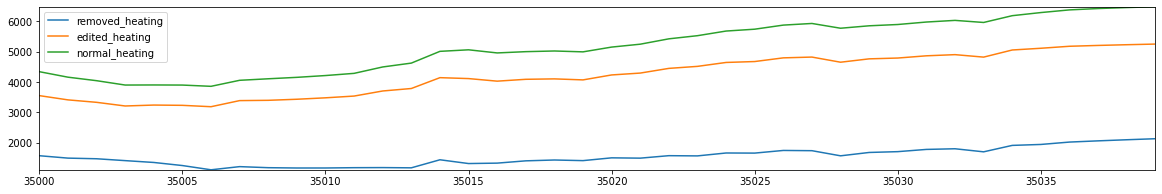

In [30]:
data = pd.DataFrame({
    'normal_cooling':data_dict['ideal_load']['cooling_load'],
    'normal_heating':data_dict['ideal_load']['heating_load'],
})
data['normal_cooling'] *= -1
load_data = pd.read_csv('test_load.csv')
load_data = load_data.merge(data,left_index=True,right_index=True)
load_data[['removed_heating','edited_heating','normal_heating']].iloc[35000:40000].plot(figsize=(20,3))

<AxesSubplot:>

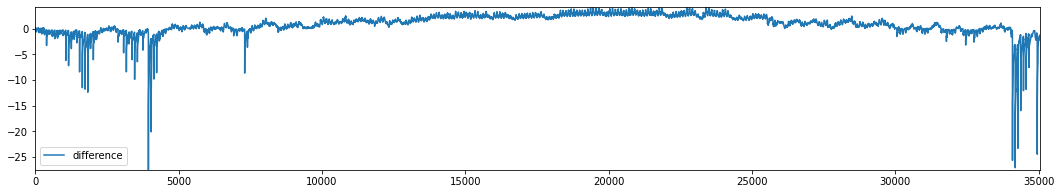

In [66]:
data = pd.DataFrame({k:v['temperature']['air_temperature'] for k, v in data_dict['simulation'].items() if 'temperature' in v.keys()})
data
data['difference'] = data[-1] - data[0]
data[['difference']].plot(figsize=(18,3))

In [20]:
query = """
SELECT
    r.TimeIndex AS timestep,
    d.Name as name,
    r.Value AS value
FROM ReportData r
INNER JOIN ReportDataDictionary d ON d.ReportDataDictionaryIndex = r.ReportDataDictionaryIndex
LEFT JOIN Zones z ON z.ZoneName = d.KeyValue
WHERE d.Name IN ('Zone Air System Sensible Cooling Rate','Zone Air System Sensible Heating Rate')
"""
data = iteration_simulator.get_database().query_table(query)
data['value'].sum()
# data = data.pivot(index='timestep',columns='name',values='value')
# data['difference'] = data.iloc[:,0] - data.iloc[:,1]
# data.plot(figsize=(16,3))

0.0

In [22]:
db.get_table('zone_metadata')

,zone_index,zone_name,multiplier,volume,floor_area,total_floor_area_proportion,conditioned_floor_area_proportion,is_cooled,is_heated,average_cooling_setpoint,average_heating_setpoint
0,1,GARAGE ZONE,1.0,65.242015,26.756076,0.127309,0.0,0,0,NaN,NaN
1,2,LIVING ZONE,1.0,276.372423,113.341709,0.539294,1.0,1,1,22.487062,18.611111
2,3,RES DS RES AC ASYS RET AIR ZONE,1.0,0.250000,0.010000,0.000048,0.0,0,0,NaN,NaN
3,4,RES DS RES FUR GAS ASYS RET AIR ZONE,1.0,0.250000,0.010000,0.000048,0.0,0,0,NaN,NaN
4,5,UNFINISHED ATTIC ZONE,1.0,10.000000,70.048892,0.333302,0.0,0,0,NaN,NaN


<AxesSubplot:xlabel='TimeIndex'>

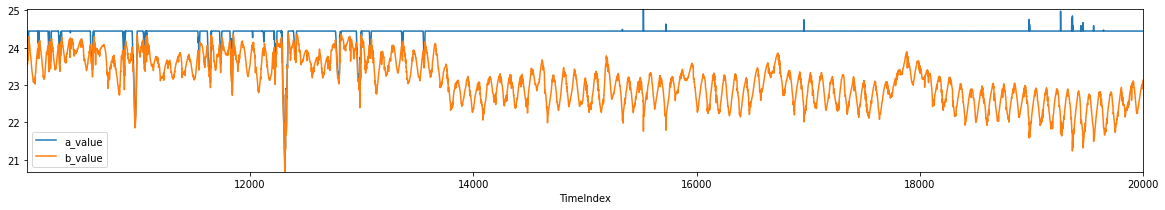

In [88]:
filepath = '/Users/kingsleyenweye/Desktop/INTELLIGENT_ENVIRONMENT_LAB/doe_xstock/energyplus_simulation/output_301430/301430.sql'
db = SQLiteDatabase(filepath)
query = """
-- weighted variables
SELECT
    r.TimeIndex,
    d.Name,
    r.ReportDataDictionaryIndex,
    r.Value AS Value
FROM ReportData r
LEFT JOIN ReportDataDictionary d ON d.ReportDataDictionaryIndex = r.ReportDataDictionaryIndex
INNER JOIN (SELECT * FROM Zones WHERE ZoneName = 'LIVING ZONE') z ON z.ZoneName = d.KeyValue
WHERE d.Name IN ('Zone Air Temperature')
"""
a = db.query_table(query)
a = a.rename(columns={'Value':'a_value'})

filepath = '/Users/kingsleyenweye/Desktop/INTELLIGENT_ENVIRONMENT_LAB/doe_xstock/energyplus_simulation/output_301430_0/301430_0.sql'
db = SQLiteDatabase(filepath)
query = """
-- site variables
SELECT
    r.TimeIndex,
    d.Name,
    r.ReportDataDictionaryIndex,
    r.Value
FROM ReportData r
LEFT JOIN ReportDataDictionary d ON d.ReportDataDictionaryIndex = r.ReportDataDictionaryIndex
WHERE d.Name IN ('Site Direct Solar Radiation Rate per Area', 'Site Outdoor Air Drybulb Temperature')

UNION

-- weighted variables
SELECT
    r.TimeIndex,
    d.Name,
    r.ReportDataDictionaryIndex,
    r.Value*z.conditioned_floor_area_proportion AS Value
FROM ReportData r
LEFT JOIN ReportDataDictionary d ON d.ReportDataDictionaryIndex = r.ReportDataDictionaryIndex
INNER JOIN (SELECT * FROM zone_metadata WHERE is_cooled + is_heated >= 1) z ON z.zone_name = d.KeyValue
WHERE d.Name IN ('Zone Air Temperature')
"""
b = db.query_table(query)
b = b[b['Name']=='Zone Air Temperature'].copy()
b = b.rename(columns={'Value':'b_value'})

c = pd.merge(a[['TimeIndex','a_value']],b[['TimeIndex','b_value']],on='TimeIndex',how='left')
c['difference'] = c['a_value'] - c['b_value']
c.set_index('TimeIndex')[['a_value','b_value']].iloc[10000:20000].plot(figsize=(20,3))

<AxesSubplot:xlabel='TimeIndex'>

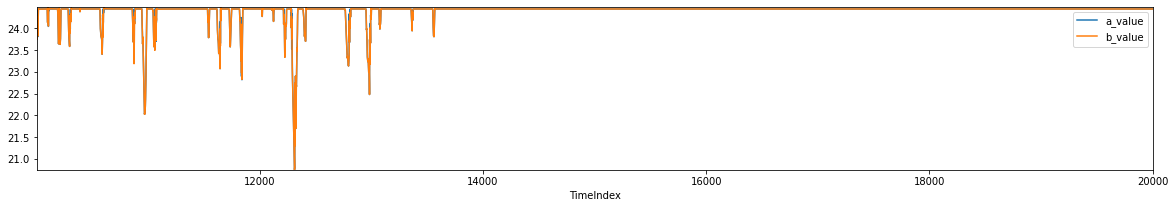

In [89]:
filepath = '/Users/kingsleyenweye/Desktop/INTELLIGENT_ENVIRONMENT_LAB/doe_xstock/energyplus_simulation/output_301430/301430.sql'
db = SQLiteDatabase(filepath)
query = """
-- weighted variables
SELECT
    r.TimeIndex,
    d.Name,
    r.ReportDataDictionaryIndex,
    r.Value AS Value
FROM ReportData r
LEFT JOIN ReportDataDictionary d ON d.ReportDataDictionaryIndex = r.ReportDataDictionaryIndex
INNER JOIN (SELECT * FROM Zones WHERE ZoneName = 'LIVING ZONE') z ON z.ZoneName = d.KeyValue
WHERE d.Name IN ('Zone Air Temperature')
"""
a = db.query_table(query)
a = a.rename(columns={'Value':'a_value'})

filepath = '/Users/kingsleyenweye/Desktop/INTELLIGENT_ENVIRONMENT_LAB/doe_xstock/energyplus_simulation/output_301430_0/301430_0.sql'
db = SQLiteDatabase(filepath)
query = """
-- site variables
SELECT
    r.TimeIndex,
    d.Name,
    r.ReportDataDictionaryIndex,
    r.Value
FROM ReportData r
LEFT JOIN ReportDataDictionary d ON d.ReportDataDictionaryIndex = r.ReportDataDictionaryIndex
WHERE d.Name IN ('Site Direct Solar Radiation Rate per Area', 'Site Outdoor Air Drybulb Temperature')

UNION

-- weighted variables
SELECT
    r.TimeIndex,
    d.Name,
    r.ReportDataDictionaryIndex,
    r.Value*z.conditioned_floor_area_proportion AS Value
FROM ReportData r
LEFT JOIN ReportDataDictionary d ON d.ReportDataDictionaryIndex = r.ReportDataDictionaryIndex
INNER JOIN (SELECT * FROM zone_metadata WHERE is_cooled + is_heated >= 1) z ON z.zone_name = d.KeyValue
WHERE d.Name IN ('Zone Air Temperature')
"""
b = db.query_table(query)
b = b[b['Name']=='Zone Air Temperature'].copy()
b = b.rename(columns={'Value':'b_value'})

c = pd.merge(a[['TimeIndex','a_value']],b[['TimeIndex','b_value']],on='TimeIndex',how='left')
c['difference'] = c['a_value'] - c['b_value']
c.set_index('TimeIndex')[['a_value','b_value']].iloc[10000:20000].plot(figsize=(20,3))

In [118]:
filepath = '/Users/kingsleyenweye/Desktop/INTELLIGENT_ENVIRONMENT_LAB/doe_xstock/energyplus_simulation/output_301430_0/301430_0.sql'
db = SQLiteDatabase(filepath)
query = """
WITH u AS (
    -- site variables
    SELECT
        r.TimeIndex,
        r.ReportDataDictionaryIndex,
        'site_variable' AS label,
        r.Value
    FROM ReportData r
    LEFT JOIN ReportDataDictionary d ON d.ReportDataDictionaryIndex = r.ReportDataDictionaryIndex
    WHERE d.Name IN ('Site Direct Solar Radiation Rate per Area', 'Site Outdoor Air Drybulb Temperature')

    UNION

    -- weighted conditioned zone variables
    SELECT
        r.TimeIndex,
        r.ReportDataDictionaryIndex,
        'weighted_variable' AS label,
        r.Value*z.conditioned_floor_area_proportion AS Value
    FROM ReportData r
    LEFT JOIN ReportDataDictionary d ON d.ReportDataDictionaryIndex = r.ReportDataDictionaryIndex
    INNER JOIN (SELECT * FROM zone_metadata WHERE is_cooled + is_heated >= 1) z ON z.zone_name = d.KeyValue
    WHERE d.Name IN ('Zone Air Temperature')

    UNION

    -- thermal load variables
    SELECT
        r.TimeIndex,
        r.ReportDataDictionaryIndex,
        CASE WHEN r.Value > 0 THEN 'heating_load' ELSE 'cooling_load' END AS label,
        ABS(r.Value) AS Value
    FROM ReportData r
    LEFT JOIN ReportDataDictionary d ON d.ReportDataDictionaryIndex = r.ReportDataDictionaryIndex
    WHERE 
        d.Name = 'Other Equipment Convective Heating Rate' AND
        (d.KeyValue LIKE '%HEATING LOAD' OR d.KeyValue LIKE '%COOLING LOAD')

    UNION

    -- other variables
    SELECT
        r.TimeIndex,
        r.ReportDataDictionaryIndex,
        'occupant_count' AS label,
        r.Value
    FROM ReportData r
    LEFT JOIN ReportDataDictionary d ON d.ReportDataDictionaryIndex = r.ReportDataDictionaryIndex
    WHERE 
        d.Name = 'Zone People Occupant Count'
), s AS (
    SELECT
        TimeIndex,
        ReportDataDictionaryIndex,
        label,
        SUM(Value) AS Value
    FROM u
    GROUP BY
        TimeIndex,
        ReportDataDictionaryIndex,
        label
), p AS (
    SELECT
        s.TimeIndex,
        MAX(CASE WHEN d.Name = 'Site Direct Solar Radiation Rate per Area' THEN Value END) AS direct_solar_radiation,
        MAX(CASE WHEN d.Name = 'Site Outdoor Air Drybulb Temperature' THEN Value END) AS outdoor_air_temperature,
        MAX(CASE WHEN d.Name = 'Zone Air Temperature' THEN Value END) AS average_indoor_air_temperature,
        MAX(CASE WHEN d.Name = 'Zone People Occupant Count' THEN Value END) AS occupant_count,
        MAX(CASE WHEN s.label = 'cooling_load' THEN Value END) AS cooling_load,
        MAX(CASE WHEN s.label = 'heating_load' THEN Value END) AS heating_load
    FROM s
    LEFT JOIN ReportDataDictionary d ON d.ReportDataDictionaryIndex = s.ReportDataDictionaryIndex
    GROUP BY TimeIndex
)
SELECT
    t.Month AS month,
    t.Day AS day,
    t.DayType AS day_name,
    CASE
        WHEN t.DayType = 'Monday' THEN 1
        WHEN t.DayType = 'Tuesday' THEN 2
        WHEN t.DayType = 'Wednesday' THEN 3
        WHEN t.DayType = 'Thursday' THEN 4
        WHEN t.DayType = 'Friday' THEN 5
        WHEN t.DayType = 'Saturday' THEN 6
        WHEN t.DayType = 'Sunday' THEN 7
        WHEN t.DayType = 'Holiday' THEN 8
        ELSE NULL
    END AS day_of_week,
    t.Hour AS hour,
    t.Minute AS minute,
    p.direct_solar_radiation,
    p.outdoor_air_temperature,
    p.average_indoor_air_temperature,
    p.occupant_count,
    COALESCE(p.cooling_load, 0) AS cooling_load,
    COALESCE(p.heating_load, 0) AS heating_load
FROM p
LEFT JOIN Time t ON t.TimeIndex = p.TimeIndex
WHERE t.DayType NOT IN ('SummerDesignDay', 'WinterDesignDay')
"""
db.query_table(query)

,month,day,day_name,day_of_week,hour,minute,direct_solar_radiation,outdoor_air_temperature,average_indoor_air_temperature,occupant_count,cooling_load,heating_load
0,1,1,Monday,1,0,15,0.0,10.45,20.581584,2.0,0.0,0.000000
1,1,1,Monday,1,0,30,0.0,10.30,20.346848,2.0,0.0,0.000000
2,1,1,Monday,1,0,45,0.0,10.15,20.116283,2.0,0.0,0.000000
3,1,1,Monday,1,1,0,0.0,10.00,19.931044,3.0,0.0,0.000000
4,1,1,Monday,1,1,15,0.0,10.00,19.779950,3.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
35035,12,31,Monday,1,23,0,0.0,0.00,19.444433,2.0,0.0,5117.346863
35036,12,31,Monday,1,23,15,0.0,0.00,19.444433,2.0,0.0,5183.146286
35037,12,31,Monday,1,23,30,0.0,0.00,19.444434,2.0,0.0,5210.699229
35038,12,31,Monday,1,23,45,0.0,0.00,19.444434,2.0,0.0,5234.277717


In [115]:
query = """
SELECT
    r.TimeIndex,
    r.Value AS Value
FROM ReportData r
LEFT JOIN ReportDataDictionary d ON d.ReportDataDictionaryIndex = r.ReportDataDictionaryIndex
WHERE d.Name IN ('Other Equipment Convective Heating Rate') AND d.KeyValue = 'LIVING ZONE HEATING LOAD'
"""
db.query_table(query)

,TimeIndex,Value
0,1,0.000000
1,2,0.000000
2,3,0.000000
3,4,0.000000
4,5,0.000000
...,...,...
35035,35036,5117.346863
35036,35037,5183.146286
35037,35038,5210.699229
35038,35039,5234.277717


In [109]:
db.query_table("SELECT KeyValue FROM ReportDataDictionary ")

,KeyValue
0,LIVING ZONE COOLING LOAD
1,LIVING ZONE HEATING LOAD
